# Convolutional Neural Network for Binary classification

In this notebook we will illustrate how we can use the machine learning framework to build a binary classification model
with a Convolutional Neural Network (CNN).

the dataset can be found here: https://github.com/mrdbourke/tensorflow-deep-learning/tree/main?tab=readme-ov-file

the idea is to illustrate what is a CNN is and how it is really suited to classification of images (among other) in place of more classical dense architecture. We will be using TensorFlow for this exercice. 

In particular, we will use the classical Machine Learning Framework:

1. Load and prepare the data
2. Choose or build a model
3. Fit the model onto the data
4. Evaluate the model
5. Improve the model
6. Save the model

Load the relevant packages

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
print(tf.__version__)

2.6.0


## 1. Load and prepare the data

In this section, we investigate the data. The data are already processed and put into nice folders (train and test sets). So what we need to do is check what kind of data we are dealing with and format them so we can feed our CNN. It means that data must have the shape of tensors !

In particular:
- the data must be normalized (values between 0 and 1). Indeed Neural Networks prefer normalized data
- the data must be split (already done)
- Check for unbalances set (is a category more represented than an other one ?)
- the data must be shuffled to feed the model in order to reduce overfitting to the training set
- we need to understand what we are dealing with

From there we will have the first insights to build our base model.

In [3]:
# Load the data
import pathlib as p
directory = p.Path(".") # the current directory


In [4]:
# train and test directories respective paths:
train_directory = directory  / "pizza_steak" / "train"
test_directory = directory  / "pizza_steak" / "test"


In [260]:
# test to see what we have inside our directories: 
def extract_folder_information(folder: p.Path) -> int:
    """ 
    Function allowing to display the number of data in each folder of interest
    """
    for item in folder.rglob("*"):
        if item.is_dir(): 
            files = [f for f in item.iterdir() if f.is_file()]
            print(f"There are {len(files)} images in {item.name} in the {folder.name} set")

    return len(files)

In [261]:
num_training = extract_folder_information(train_directory)

There are 750 images in steak in the train set
There are 750 images in pizza in the train set


In [262]:
extract_folder_information(test_directory)

There are 250 images in steak in the test set
There are 250 images in pizza in the test set


250

Ok so now we have a better idea of how our data is grouped into training and test sets. Furthermore, we can see that our training data is well balanced between the two classes. Now it could be nice to check what our data looks like. Before doing so, we can extract the classes we will be 

In [8]:
# extraction of the classes we want to learn from:
class_names = [names.stem for names in train_directory.iterdir()]
class_names

['steak', 'pizza']

So we have two classes: steak and pizza. We can get into each folder and checkout how the data look like by plotting the images randomly. So this is what we are going to do in the following

In [9]:
def see_data(direct: p.Path, classe: str, display, *args: int) -> Image.Image:
    """
    Function used to display the data we are dealing with for binary image classification
    """
    path = direct / classe
    list_train_data = [item.name for item in path.iterdir() if item.is_file()]
    for num in args:
        new_path = direct / classe / list_train_data[num]
        img = Image.open(new_path)
        if display:
            plt.imshow(img)
            plt.axis(False)
            plt.title(f"Class: {classe}")
    return img

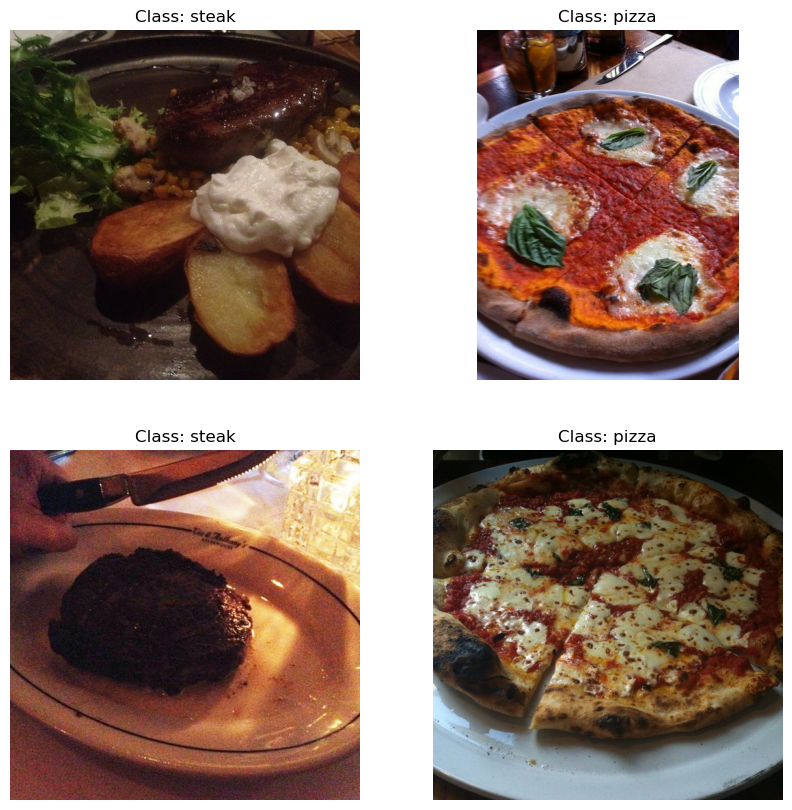

In [12]:
# Let's now plot our data:
import random as rand
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
see_data(train_directory, "steak", True, rand.randint(0, num_training))
plt.subplot(2,2,2)
see_data(train_directory, "pizza", True, rand.randint(0, num_training))
plt.subplot(2,2,3)
see_data(train_directory, "steak", True, rand.randint(0, num_training))
plt.subplot(2,2,4)
see_data(train_directory, "pizza", True, rand.randint(0, num_training))
plt.show()

So what we know so far is that we have a balanced data set between pizza's and steaks. The data is in a `*.jpg`form. But what is the form factor of the image

In [11]:
# data type of the images:
type(see_data(train_directory, "pizza", False, rand.randint(0, num_training)))

PIL.JpegImagePlugin.JpegImageFile

So we do not have a data type that is manageable by our future Neural Network. Indeed we need a tensor form factor (or at least an array that is handled quiet well by TensorFlow). So it seems that we can either load each and every image and turned them into tensors or we can use a prebuild function offer by TensorFlow to achieve this: `ImageDataGenerator` !

information here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

**Note**: In TensorFlow > 2.9 this Class is deprecated ! A new way of performing the steps we will take after this cell is adovated but since we are using TensorFlow 2.6, we will use the `ImageDataGenerator` class. You can find more information here: 

https://community.deeplearning.ai/t/imagedatagenerator-is-deprecated-in-tensorflow-2-9/129747

In [13]:
# Prepare the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

training_data = train_data_gen.flow_from_directory(train_directory,
                                                   class_mode="binary",
                                                   seed = 42,
                                                   batch_size=32
                                                  )
testing_data = test_data_gen.flow_from_directory(test_directory,
                                                 class_mode="binary",
                                                 seed = 42,
                                                 batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


So what this does: 
- We create instances of the `ImageDataGenerator` passing a rescale parameters to have the numerical values between 0 and 1. Indeed, we know that what the output of this will be is a numerical representation of the images with the color channels per pixels between 0 and 255 (R-G-B). A good practice for Neural Network is to normalize or standardize the input values
- Then we pul the data from the directory using the `flow_from_directory()`method. We specify also the bath size (32 is by default though), we set a seed for reproductibility of results and we specify the directory where our data are located. Because of the way the data are classified into nice folders, the method finds what we want: 2 classes with a total of 1500 images !

Now what we have our date, the last step is to check that they are in a correct form before feedind it to our Neural Network !

In [28]:
# visualizing the data after preparing it
data = training_data[0]
data[0].shape, len(data)

((32, 256, 256, 3), 2)

In [29]:
type(data[0]), type(data[1])

(numpy.ndarray, numpy.ndarray)

So the output ouf the `flow_from_directory()`method is a tuple of size 2. The first item in the tuple is our images (the features) and the second item is our labels (here `steak` of `pizza`).

the type of data is numpy arrays ! This is not a tensor per say BUT tensorflow accepts numpy arrays as inputs. We have a 4 dimensionnal numpy array of this form: `(batch_size, height, widht, color_channel)`. 

Let's keep investigate a little bit more on the data we get from our preprocessing ! 

In [33]:
data[0], data[1]

(array([[[[0.42352945, 0.43137258, 0.34509805],
          [0.31764707, 0.3254902 , 0.2392157 ],
          [0.26666668, 0.28235295, 0.18431373],
          ...,
          [0.41960788, 0.34117648, 0.38431376],
          [0.44705886, 0.3647059 , 0.42352945],
          [0.43921572, 0.35686275, 0.42352945]],
 
         [[0.2901961 , 0.30588236, 0.21568629],
          [0.45882356, 0.47450984, 0.37647063],
          [0.2627451 , 0.28627452, 0.18431373],
          ...,
          [0.4156863 , 0.35686275, 0.36862746],
          [0.40784317, 0.36078432, 0.37647063],
          [0.38823533, 0.3372549 , 0.3647059 ]],
 
         [[0.25882354, 0.28235295, 0.18039216],
          [0.4431373 , 0.4666667 , 0.3647059 ],
          [0.28235295, 0.30588236, 0.20392159],
          ...,
          [0.3803922 , 0.34117648, 0.33333334],
          [0.35686275, 0.3254902 , 0.31764707],
          [0.36862746, 0.3372549 , 0.32941177]],
 
         ...,
 
         [[0.5137255 , 0.5058824 , 0.54901963],
          [0.51764

In [35]:
training_data.class_indices

{'pizza': 0, 'steak': 1}

Looking on how our classes are stored, we now know that a label of `0`stands for `pizza`and a label of `1`stands for steak. This will be important when we will get the results of a prediction since the outputs of our model will be a number ! so in order to get a human like information we will be needing to map this number to either `0`or `1` ! But we will come to that later on !

**Note**: you may wonder ... ok but I see that I have only 32 images there since I have a size 32 but I have 1500 training images so where are they ? Good question: the thing is that `ImageDataGenerator`only pulls the data batch by batch (for memory space efficiency). So when you will pass this data to the Neural Network, using the `training_data` object will induced a call to the relevant folder and pull another batch until all the batches went through our model. This is a process that is repeated for each epochs as we will see. So we must expect per epochs to have 47 steps !

## 2. Build or choose a model

In this section we will build two models:
1. A dense model to test its performances and
2. A CNN model to illustrate the performances with respect to the classical dense model

the goal is to illustrate what we gain from using CNN for image classification. We will then improve the model in the next section. But first we will build a test model to see if everything works properly (we will fit it in section 3)

### Build a CNN model

In [57]:
# Build a model to see if the data is loaded properly and if the models runs: use a CNN 
tf.random.set_seed(42)
# 1. Build the model
model_1 = tf.keras.models.Sequential([    
    tf.keras.Input(shape=(256,256,3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) # we can use accuracy since we have a balanced dataset !

Let's build next a regular dense Neural Network to compare it to our CNN. Note that we have quiet non-linear pattern in our images so we will be needing several layers with a certain number of hidden fearures as well as activation functions to account for non linearities. 

### Build a Dense Neural Network

In [66]:
# 1. Build the model 

model_2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(256,256,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")                   
])

# 2. Compile the model

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## 3. Fit the model

In this section we will fit our models and see how it  behave by illustrating the achieved performances with a CNN and a more classical dense Neural Network (for image classification)

In [68]:
# Fit the CNN 
history_1 = model_1.fit(training_data, epochs=5, validation_data=testing_data)

Epoch 1/5
47/47 [==============================] - 16s 327ms/step - loss: 0.1159 - accuracy: 0.9700 - val_loss: 0.3233 - val_accuracy: 0.8560
Epoch 2/5
47/47 [==============================] - 16s 340ms/step - loss: 0.0781 - accuracy: 0.9867 - val_loss: 0.3834 - val_accuracy: 0.8340
Epoch 3/5
47/47 [==============================] - 18s 379ms/step - loss: 0.0591 - accuracy: 0.9900 - val_loss: 0.3431 - val_accuracy: 0.8580
Epoch 4/5
47/47 [==============================] - 17s 365ms/step - loss: 0.0435 - accuracy: 0.9947 - val_loss: 0.3697 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 18s 372ms/step - loss: 0.0547 - accuracy: 0.9907 - val_loss: 0.3541 - val_accuracy: 0.8560


In [67]:
# Fit the Dense Neural Network
history_2 = model_2.fit(training_data, epochs=5, validation_data=testing_data)

Epoch 1/5
47/47 [==============================] - 10s 213ms/step - loss: 2.0916 - accuracy: 0.5760 - val_loss: 3.3193 - val_accuracy: 0.5700
Epoch 2/5
47/47 [==============================] - 10s 215ms/step - loss: 0.9146 - accuracy: 0.7300 - val_loss: 0.4616 - val_accuracy: 0.7920
Epoch 3/5
47/47 [==============================] - 10s 204ms/step - loss: 0.5125 - accuracy: 0.7680 - val_loss: 0.4547 - val_accuracy: 0.7780
Epoch 4/5
47/47 [==============================] - 9s 183ms/step - loss: 0.5634 - accuracy: 0.7453 - val_loss: 0.4447 - val_accuracy: 0.7880
Epoch 5/5
47/47 [==============================] - 9s 182ms/step - loss: 0.4672 - accuracy: 0.7813 - val_loss: 0.4474 - val_accuracy: 0.7800


We can see several things from this experiment:

- the CNN provides better accuracy on our training and test data sets. We can see from this the interest of build a CNN and it will even more emphasized in the next section when we will have a deeper look at the architectures of our models.
- The CNN seems to predict the testing data with good accuracy and lower than the training data (so there is no overfitting it seems which is a good news). We will try to improve the model in section 5.

## 4. Evaluate the model

Now let's take a deeper dive into the model metrics. We will display the performances as well as the underlying architecture of our models in order to assess their respective performances. 

### Models architecture

In [69]:
# lets put forward the models architectures !
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 10)      280       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 10)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 161290)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 161291    
Total params: 161,571
Trainable params: 161,571
Non-trainable params: 0
_________________________________________________________________


In [70]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                9830450   
_________________________________________________________________
dense_31 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_32 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_33 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_34 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

As we can clearly see, using a fully connected model (Dense Neural Network) requires way more parameters to achieve less performances that our simple CNN. This illustrate perfectyl why in our application, i.e., image classification, CNN are better suited. 

### Model performances summary

In [93]:
# Cast the history into dataframe
data_m1 = pd.DataFrame(history_1.history)
data_m2 = pd.DataFrame(history_2.history)
data_m1

,loss,accuracy,val_loss,val_accuracy
0,0.115860,0.970000,0.323273,0.856
1,0.078144,0.986667,0.383430,0.834
2,0.059106,0.990000,0.343148,0.858
3,0.043461,0.994667,0.369739,0.852
4,0.054703,0.990667,0.354078,0.856


In [94]:
data_m2

,loss,accuracy,val_loss,val_accuracy
0,2.091642,0.576000,3.319320,0.570
1,0.914570,0.730000,0.461561,0.792
2,0.512482,0.768000,0.454672,0.778
3,0.563401,0.745333,0.444651,0.788
4,0.467211,0.781333,0.447422,0.780


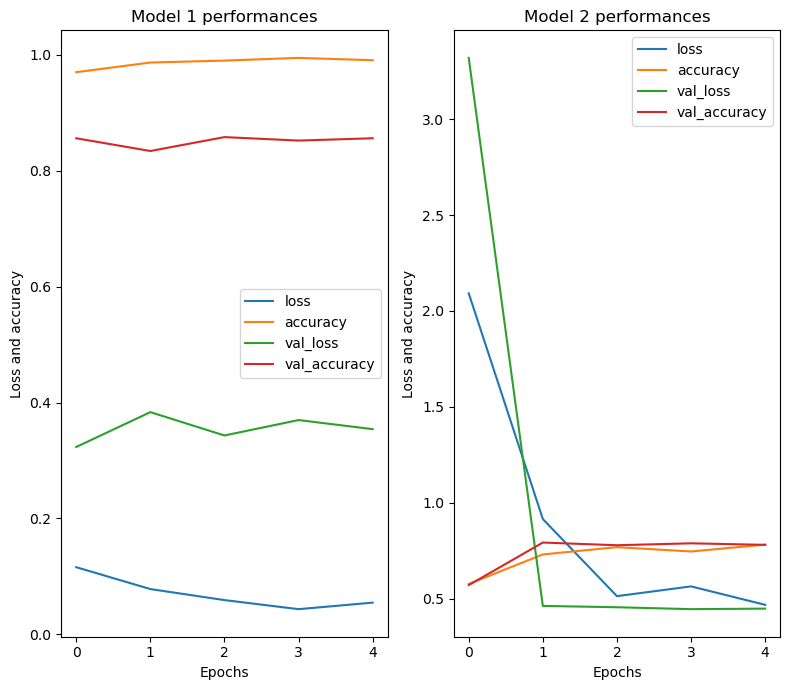

In [97]:
# let's plot the evolution of the loss curve and accuracy curve

fig, ax = plt.subplots(1,2, figsize=(8,7));
ax[0].plot(data_m1, label=["loss","accuracy","val_loss","val_accuracy"]);
ax[0].set_title("Model 1 performances")
ax[0].set_xlabel("Epochs");
ax[0].set_ylabel("Loss and accuracy");
ax[0].legend()

ax[1].plot(data_m2, label=["loss","accuracy","val_loss","val_accuracy"]);
ax[1].set_title("Model 2 performances")
ax[1].set_xlabel("Epochs");
ax[1].set_ylabel("Loss and accuracy");
ax[1].legend()

plt.tight_layout()
plt.show()



In [99]:
# Evaluate the "accuracy" metric
pred_m1 = model_1.evaluate(testing_data)

16/16 [==============================] - 3s 170ms/step - loss: 0.3541 - accuracy: 0.8560


In [100]:
pred_m2 = model_2.evaluate(testing_data)

16/16 [==============================] - 2s 114ms/step - loss: 0.4474 - accuracy: 0.7800


In [102]:
pred_m1, pred_m2

([0.35407814383506775, 0.8560000061988831],
 [0.4474220275878906, 0.7799999713897705])

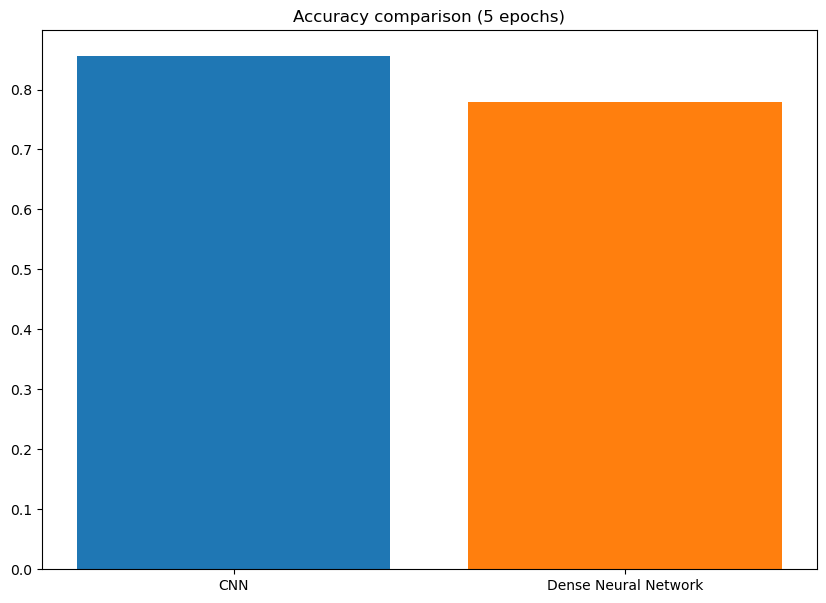

In [113]:
plt.figure(figsize=(10,7))
plt.bar(1,pred_m1[1])
plt.bar(2,pred_m2[1])
plt.xticks([1, 2], ['CNN', 'Dense Neural Network'])
plt.title("Accuracy comparison (5 epochs)")
plt.show()

So it is clear that the CNN is a better candidate for image classification. So in the next section, we will try and improve this model in order to have better performances and try to make predictions on custom data (like the pizza or steak we might have eaten :-) ).

## 5. Improve the model

In [114]:
# Let's try to build a better CNN model
tf.random.set_seed(42)
#1. Build a model
model_3 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(256,256,3)),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
#2. Compile a model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#3. Fir the model
model_3.fit(training_data, epochs=5, validation_data=testing_data)

Epoch 1/5
47/47 [==============================] - 48s 1s/step - loss: 0.5527 - accuracy: 0.7100 - val_loss: 0.4469 - val_accuracy: 0.7860
Epoch 2/5
47/47 [==============================] - 47s 1s/step - loss: 0.4316 - accuracy: 0.8060 - val_loss: 0.3745 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 51s 1s/step - loss: 0.3888 - accuracy: 0.8380 - val_loss: 0.3150 - val_accuracy: 0.8680
Epoch 4/5
47/47 [==============================] - 47s 1s/step - loss: 0.3443 - accuracy: 0.8527 - val_loss: 0.3902 - val_accuracy: 0.8240
Epoch 5/5
47/47 [==============================] - 49s 1s/step - loss: 0.3237 - accuracy: 0.8633 - val_loss: 0.3052 - val_accuracy: 0.8760


When we take a look it seems that our model performs as good as on the training data. Here is a list of what can be done to try and improve it:

- increase the number of data or improve the quality of the data
- let the model train for longer
- increase the model complexity
- shuffling the data in order to avoid finding patterns for just a certain part of the data
- For image classification in particular we can do data augmentation
- Fine tune the learning rate
- use transfer learning (not covered here but worht pointing out)

Well in this example we do not have more data (we could grab some from the internet and enrich our training and testing set). 

Increasing the model complexity might lead to  issues or overfitting and we see that we a more complex architecture the gain is that high. 

The data are intrinsquely already shuffled when we pulled them from their respective folders so no need to do anything there. 

We could try to improve the accuracy of the model by fine tuning the optimizer but when we see where we are at maybed there is something we can do first ... and indeed there is ! Data augmentation ! What is that ? Well this the process of artificially increase the data set ... without increasing its size :o. So in other term, it boils down to  appyling some image transformation in order to help the model to better generalize. So this is what we will do.

### Data augmentation

**Note**: Data augmentation is performed only on the training data set !

In [115]:
# Data augmentation
train_data_gen_augm = ImageDataGenerator(rescale=1/255.,
                                         rotation_range=0.2,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2)

In [116]:
train_data_augm = train_data_gen_augm.flow_from_directory(directory=train_directory,
                                                          target_size=(256,256),
                                                          class_mode="binary",
                                                          batch_size=32,
                                                          seed=42)

Found 1500 images belonging to 2 classes.


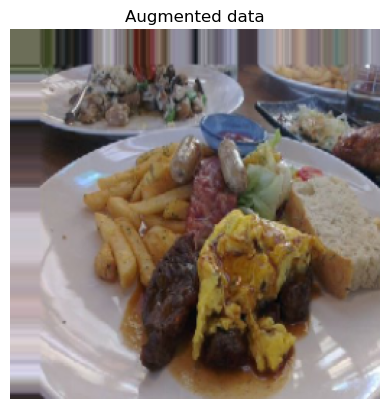

In [125]:
# let's see our data:
plt.imshow(train_data_augm[0][0][0]);
plt.axis(False);
plt.title("Augmented data");


So the result is some modification on the image with the operations we specified in our `ImageDataGenerator`. Now we are going to test our model again

In [128]:
tf.random.set_seed(42)
# 1. Build the model
model_4 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(256,256,3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.Conv2D(10,3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
# 2. Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# 3. Fit the model
history_4 = model_4.fit(train_data_augm, epochs=10, validation_data=testing_data)

Epoch 1/10
47/47 [==============================] - 55s 1s/step - loss: 0.5809 - accuracy: 0.6980 - val_loss: 0.3870 - val_accuracy: 0.8540
Epoch 2/10
47/47 [==============================] - 56s 1s/step - loss: 0.4805 - accuracy: 0.7787 - val_loss: 0.3316 - val_accuracy: 0.8720
Epoch 3/10
47/47 [==============================] - 55s 1s/step - loss: 0.4929 - accuracy: 0.7633 - val_loss: 0.3696 - val_accuracy: 0.8500
Epoch 4/10
47/47 [==============================] - 55s 1s/step - loss: 0.4725 - accuracy: 0.7920 - val_loss: 0.3848 - val_accuracy: 0.8360
Epoch 5/10
47/47 [==============================] - 55s 1s/step - loss: 0.4578 - accuracy: 0.7920 - val_loss: 0.3268 - val_accuracy: 0.8640
Epoch 6/10
47/47 [==============================] - 55s 1s/step - loss: 0.4303 - accuracy: 0.8080 - val_loss: 0.3541 - val_accuracy: 0.8620
Epoch 7/10
47/47 [==============================] - 55s 1s/step - loss: 0.4186 - accuracy: 0.8147 - val_loss: 0.3116 - val_accuracy: 0.8760
Epoch 8/10
47/47 [==

Well we have slightly improve the model but barely. Let's try to use our `model_1` with the augmented data:

In [132]:
# using model_1 but with augmented data
# 1. build model
model_5 = tf.keras.models.clone_model(model_1)
# 2. compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# 3. Fit
model_5.fit(train_data_augm, epochs=10, validation_data=testing_data)


Epoch 1/10
47/47 [==============================] - 34s 715ms/step - loss: 0.7837 - accuracy: 0.6587 - val_loss: 0.5061 - val_accuracy: 0.7700
Epoch 2/10
47/47 [==============================] - 35s 735ms/step - loss: 0.5627 - accuracy: 0.7253 - val_loss: 0.4615 - val_accuracy: 0.7900
Epoch 3/10
47/47 [==============================] - 35s 749ms/step - loss: 0.5509 - accuracy: 0.7360 - val_loss: 0.4044 - val_accuracy: 0.8100
Epoch 4/10
47/47 [==============================] - 36s 767ms/step - loss: 0.5191 - accuracy: 0.7540 - val_loss: 0.3911 - val_accuracy: 0.8260
Epoch 5/10
47/47 [==============================] - 37s 790ms/step - loss: 0.4989 - accuracy: 0.7573 - val_loss: 0.3736 - val_accuracy: 0.8320
Epoch 6/10
47/47 [==============================] - 36s 765ms/step - loss: 0.4963 - accuracy: 0.7593 - val_loss: 0.3991 - val_accuracy: 0.8180
Epoch 7/10
47/47 [==============================] - 35s 737ms/step - loss: 0.4921 - accuracy: 0.7700 - val_loss: 0.4389 - val_accuracy: 0.7920

It seems that using model 1 leads to less accurate results ! so our best model is `model_5`and this is the one we are going to save

## 6. Save the model

In [133]:
# saving the model to be able to reload it later when needed or use it in an app !
model_5.save("model_final")

2024-09-26 21:53:05.265525: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_final/assets


In [134]:
model_5.save("model_final.keras")

## 7. Evaluate the model on a personal image

In [136]:
# load the model
loaded_model = tf.keras.models.load_model("model_final.keras")

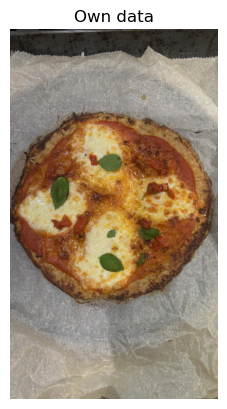

In [145]:
# load our image and display it
path_to_data = p.Path(".")
img = Image.open(path_to_data / "data.jpg")
plt.imshow(img)
plt.axis(False)
plt.title("Own data")
plt.show()

In [146]:
# type of the image
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [154]:
# conversion to a numpy array
img_as_array = np.array(img)/255.

From there we can cast this into a tensor or not (TensorFlow can handle nummpy arrays). But what we need to ensure is that the shape of our data fits the expected shape to pass to our model ! Let's do that !

In [155]:
img_as_array.shape

(4032, 2268, 3)

In [156]:
img_as_tensor = tf.constant(img_as_array)

In [160]:
img_as_tensor_resized = tf.image.resize(img_as_tensor, [256,256])

In [161]:
# check of the dimensions
img_as_tensor_resized.shape

TensorShape([256, 256, 3])

Ok so we have properly casted our image but one last step ! indeed, remember that our input data in our CNN is batches of size (32, 256,256,3). It means that we pass to our model 32 images at a time. Individually, our input has a size (1, 256, 256, 3). So our model expect a 4 order tensor ! so we need to expand the first dimensions of our input and then we can evaluate it ! That is why is really important to have a good idea of the size of our input as our model only takes the identical shape !

In [162]:
# expand the first dimension
img_as_tensor_resized = tf.expand_dims(img_as_tensor_resized, axis=0)

In [163]:
img_as_tensor_resized.shape

TensorShape([1, 256, 256, 3])

In [164]:
# Make a prediction:
# First let's load our model
loaded_model = tf.keras.models.load_model("model_final.keras")

In [165]:
prediction = loaded_model.predict(img_as_tensor_resized)

In [166]:
prediction

array([[0.59870476]], dtype=float32)

Ok so what is this ? Well it is the binary prediction of what our image is ! Since we have two classes (binary classification) the outcome of the prediction is either `1`or `0`. So we need to determine which class is `1` (or `0`).

In [173]:
classes = training_data.class_indices
classes

{'pizza': 0, 'steak': 1}

Let's write a function that will determine which to which category belongs our data

In [236]:
def predict_class(cl: dict = classes, pr: np.array = prediction, img: Image.Image = img) -> None:
    """
    determine the class of our data and plot the prediction with the confidence of this prediction
    """
    belong_class_num = 1 if pr > 0.5 else 0
    for key, value in cl.items():
        if value == belong_class_num:
            class_prediction = key
    # plot the image and the predicted class
    plt.imshow(img)
    plt.axis(False)
    plt.title(f"The prediction is '{class_prediction}'")

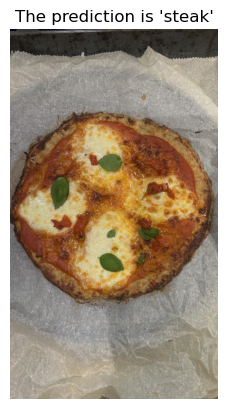

In [237]:
predict_class()

Well ... not so good ... Our image is clearly a pizza and we have predicted steak. Maybe we can try one last thing and augment this data before making the prediction.

In [238]:
# augment the data
own_data_gen = ImageDataGenerator(
                                  zoom_range=0.3
                                 )

In [244]:
data_augm = own_data_gen.flow(img_as_tensor_resized) # here we use flow() since we load directly an image !

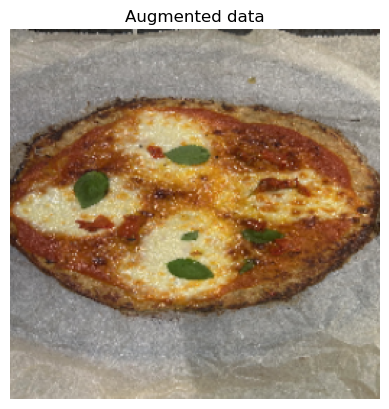

In [257]:
plt.imshow(data_augm[0][0]);
plt.title("Augmented data")
plt.axis(False)
plt.show()

In [258]:
# make a prediction
prediction2 = loaded_model(data_augm[0])

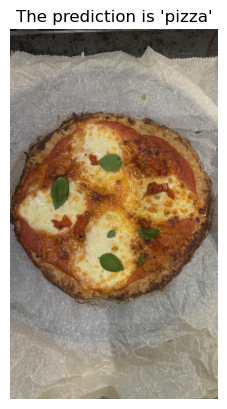

In [259]:
predict_class(pr=prediction2.numpy()) # careful the output of our prediction is a tensor ! our function required an array

By zooming in on our data, we reduces the noice and allowed our model to correctly predict that we have a pizza :)